# Analyse des ventes pour la librairie en ligne Lapage

# Sommaire

* [1. Importation et visualisation des données](#1)
* [2. Nettoyage des données](#2)
    * [2.1. Suppression des données de test](#2_1)
    * [2.2. Recherche de doublons](#2_2)
    * [2.3. Modifications des types](#2_3)
* [3. Etude du chiffre d'affaires](#3)
    * [3.1. Jointure entre 'transactions' et 'products'](#3_1)
    * [3.2. Etude du chiffre d'affaires](#3_2)
    * [3.3. Zoom sur les références](#3_3)
        * [3.3.1. Comparaison entre les références les plus vendues et les moins vendues](#3_3_1)
        * [3.3.2. Comparaison entre les références les plus vendues et les moins vendues (par catégorie)](#3_3_2)
    * [3.4. Profils des clients](#3_4)
    * [3.5. Clients outliers](#3_5)
* [4. Etude des différentes corrélations](#4)
    * [4.1. Lien entre le genre d'un client et les catégories des livres achetés](#4_1)
    * [4.2. Lien entre l'âge des clients et ...](#4_2)
        * [4.2.1. ... le montant total des achats](#4_2_1)
        * [4.2.2. ... la fréquence des achats](#4_2_2)
        * [4.2.3. ... la taille du panier moyen](#4_2_3)
        * [4.2.4. ... les catégorie de livres achetés](#4_2_4)
    * [4.3. Prix moyen d'un livre par rapport à la catégorie et à l'age moyen](#4_3)
    * [4.4. Matrice de corrélation](#4_4)
* [5. Conclusion de l'étude des corrélations](#5)

## 1. Importation et visualisation des données <a class="anchor" id="1"></a>

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
plt.style.use('seaborn-dark')

In [3]:
customers = pd.read_csv('customers.csv')
products = pd.read_csv('products.csv')
transactions = pd.read_csv('transactions.csv')

In [4]:
customers.head()

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943


In [5]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8623 entries, 0 to 8622
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8623 non-null   object
 1   sex        8623 non-null   object
 2   birth      8623 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 202.2+ KB


In [6]:
customers.describe()

,birth
count,8623.000000
mean,1978.280877
std,16.919535
min,1929.000000
25%,1966.000000
50%,1979.000000
75%,1992.000000
max,2004.000000


In [7]:
customers['sex'].unique()

array(['f', 'm'], dtype=object)

In [8]:
products.head()

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


In [9]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3287 non-null   object 
 1   price    3287 non-null   float64
 2   categ    3287 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 77.2+ KB


In [10]:
products.describe()

,price,categ
count,3287.000000,3287.000000
mean,21.856641,0.370246
std,29.847908,0.615387
min,-1.000000,0.000000
25%,6.990000,0.000000
50%,13.060000,0.000000
75%,22.990000,1.000000
max,300.000000,2.000000


In [11]:
products['categ'].unique()

array([0, 1, 2], dtype=int64)

In [12]:
transactions.head()

,id_prod,date,session_id,client_id
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232


In [13]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679532 entries, 0 to 679531
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id_prod     679532 non-null  object
 1   date        679532 non-null  object
 2   session_id  679532 non-null  object
 3   client_id   679532 non-null  object
dtypes: object(4)
memory usage: 20.7+ MB


In [14]:
transactions.describe()

,id_prod,date,session_id,client_id
count,679532,679532,679532,679532
unique,3267,679371,342316,8602
top,1_369,test_2021-03-01 02:30:02.237413,s_0,c_1609
freq,2252,13,200,25488


## 2. Nettoyage des données <a class="anchor" id="2"></a>

### 2.1. Suppression des données de test <a class="anchor" id="2_1"></a>

In [15]:
# Visualisation des valeurs aberrantes 
products.describe()

,price,categ
count,3287.000000,3287.000000
mean,21.856641,0.370246
std,29.847908,0.615387
min,-1.000000,0.000000
25%,6.990000,0.000000
50%,13.060000,0.000000
75%,22.990000,1.000000
max,300.000000,2.000000


Il y a des prix négatifs dans le fichier 'products'. Identifions les lignes. 

In [16]:
# Identification des id_prod avec prix négatives dans products
products.loc[products['price'] < 0]

,id_prod,price,categ
731,T_0,-1.0,0


Il s'agit du produit T_0. Identifions ce produit dans le dataframe transaction.

In [17]:
# Identification du produit T_0 dans transactions
id_prod_T_0 = transactions.loc[transactions['id_prod'] == 'T_0']
id_prod_T_0

,id_prod,date,session_id,client_id
3019,T_0,test_2021-03-01 02:30:02.237419,s_0,ct_0
5138,T_0,test_2021-03-01 02:30:02.237425,s_0,ct_0
9668,T_0,test_2021-03-01 02:30:02.237437,s_0,ct_1
10728,T_0,test_2021-03-01 02:30:02.237436,s_0,ct_0
15292,T_0,test_2021-03-01 02:30:02.237430,s_0,ct_0
...,...,...,...,...
657830,T_0,test_2021-03-01 02:30:02.237417,s_0,ct_0
662081,T_0,test_2021-03-01 02:30:02.237427,s_0,ct_1
670680,T_0,test_2021-03-01 02:30:02.237449,s_0,ct_1
671647,T_0,test_2021-03-01 02:30:02.237424,s_0,ct_1


In [18]:
# Il s'agit de lignes de test
# Identifions maintenant les clients de test
client_id_test = transactions.loc[transactions['id_prod'] == 'T_0']['client_id'].unique()
client_id_test

array(['ct_0', 'ct_1'], dtype=object)

In [19]:
# Vérifions si la donnée 'test' est présente sur toutes les lignes de 'date'
date_test = id_prod_T_0['date'].str.split('_').str[0].unique()
date_test

array(['test'], dtype=object)

Il s'agit bien de ligne de test. 

Le produit T_0 est un produit de test, les clients ct_0 et ct_1 sont des clients de test. 

Il faut donc les supprimer des différents dataframe. 

In [20]:
# Suppression des données de test du dataframe 'products'
products = products[products['id_prod'] != 'T_0']

In [21]:
# Suppression des données de test du dataframe 'customers'
customers = customers[(customers['client_id'] != 'ct_0')| (customers['client_id'] != 'ct_1')]

In [22]:
# Suppression des données de test du dataframe 'transactions'
transactions = transactions[transactions['id_prod'] != 'T_0']

### 2.2. Recherche de doublons <a class="anchor" id="2_2"></a>

In [23]:
# Pour le dataframe 'transactions'
transactions.loc[transactions[['date', 'client_id']].duplicated(keep=False), :]

,id_prod,date,session_id,client_id


Pas de doublons sur le dataframe 'transactions'.

In [24]:
# Pour le dataframe 'products'
products.shape

(3286, 3)

In [25]:
products['id_prod'].nunique()

3286

Pas de doublons sur le dataframe 'products'.

In [26]:
# Pour le dataframe 'customers'
customers.shape

(8623, 3)

In [27]:
customers['client_id'].nunique()

8623

Pas de doublons sur le dataframe 'customers'.

### 2.3. Modifications des types <a class="anchor" id="2_3"></a>

In [28]:
# La variable 'categ' est une variable catégorielle, on va donc changer le type
products['categ'] = products['categ'].astype(object)

In [29]:
# Mettons les dates au format 'datetime'
transactions['date'] = pd.to_datetime(transactions['date']).dt.date

# Gardons seulement l'année, le mois et le jour
transactions['date'] =  pd.to_datetime(transactions['date'], format='%Y-%m-%d')

## 3. Etude du chiffre d'affaires <a class="anchor" id="3"></a>

### 3.1. Jointure entre 'transactions' et 'products' <a class="anchor" id="3_1"></a>

In [30]:
# Utilisons une jointure 'left' pour rapprocher les 2 dataframes
transactions_products = pd.merge(transactions, products, how='left', on='id_prod')
transactions_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679332 entries, 0 to 679331
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     679332 non-null  object        
 1   date        679332 non-null  datetime64[ns]
 2   session_id  679332 non-null  object        
 3   client_id   679332 non-null  object        
 4   price       679111 non-null  float64       
 5   categ       679111 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 36.3+ MB


In [31]:
# Regardons quelles sont les références produits qui n'ont pas été rétrouvées dans 'products'
non_trouvés = transactions_products.loc[transactions_products['price'].isna()]['id_prod'].unique()
non_trouvés

array(['0_2245'], dtype=object)

In [32]:
# A quelle catégorie de produit appartient 0_2245 ? Regardons les préfixes de plus prêt
for categ in transactions_products['categ'].unique():
    catégories = transactions_products.loc[transactions_products['categ'] == categ]['id_prod']
    préfixes = catégories.str.split('_').str[0].unique()
    print(f'Catégorie : {categ}, Préfixes : {préfixes}')

Catégorie : 0, Préfixes : ['0']
Catégorie : 1, Préfixes : ['1']
Catégorie : 2, Préfixes : ['2']
Catégorie : nan, Préfixes : []


La catégorie du produit '0_2245' est donc 0. Nous allons donc calculer la moyenne des prix de la catégorie 0 pour les produits ayant déjà été vendus au moins une fois. 

Nous remplacerons les données vides du produit '0_2245' par cette moyenne. 

In [33]:
# Calculons la moyenne des prix de la catégorie ('0') dans le fichier des transactions
m_categ0 = transactions_products.loc[transactions_products['categ'] == 0]['price'].mean()

# Remplaçons les données vides
transactions_products['price'] = transactions_products['price'].fillna(m_categ0)
transactions_products['categ'] = transactions_products['categ'].fillna(0)

### 3.2. Etude du chiffre d'affaires <a class="anchor" id="3_2"></a>

In [34]:
# Création d'un dataframe avec la colonne date en index
transactions_products_tempo = transactions_products.set_index('date')

In [35]:
# Modification du format d'affichage des nombres
pd.options.display.float_format = '{:.2f}'.format

# Calcul du CA total
CA_total = round(transactions_products_tempo['price'].sum(),2)
print(f"Le chiffre d'affaires total est de {CA_total}€.")
print() # Insertion d'une ligne vide (espace)

# Calcul du CA par année
ca_années = transactions_products_tempo['price'].resample('Y').agg(['sum']).rename(columns={'sum':"Chiffre d'affaires"}).reset_index()
print("Le chiffre d'affaires par année :")
display(ca_années)

Le chiffre d'affaires total est de 11856079.72€.

Le chiffre d'affaires par année :


,date,Chiffre d'affaires
0,2021-12-31,4771752.08
1,2022-12-31,6109958.39
2,2023-12-31,974369.24


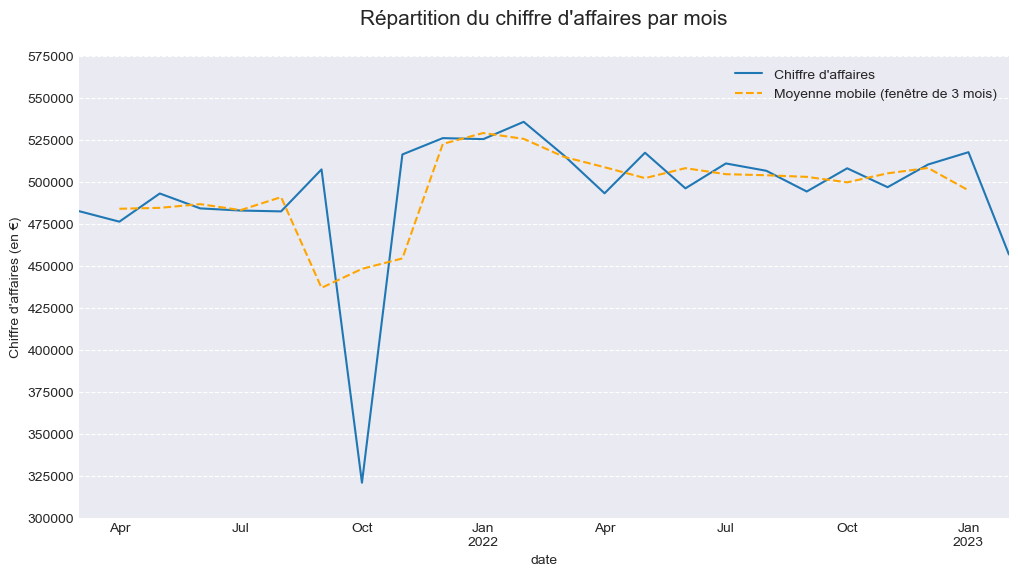

In [36]:
# Création d'un dataframe pour la somme du CA par mois
ca_mois = transactions_products_tempo['price'].resample('M').agg(['sum'])

# Graphique
plt.figure(figsize=(12,6))
plt.title("Répartition du chiffre d'affaires par mois", fontsize=15, y=1.05)
ca_mois['sum'].plot(label="Chiffre d'affaires")
ca_mois['sum'].rolling(window=3, center=True).mean().plot(label='Moyenne mobile (fenêtre de 3 mois)', ls='--', color='orange')
plt.ylabel("Chiffre d'affaires (en €)", fontsize=10)
plt.yticks(np.arange(300000,600000,25000))
plt.grid(axis='y', linestyle = 'dashed')
plt.legend()
plt.show()

Essayons de lisser un peu plus la courbe en prennant les données de chiffre d'affaires par jour.

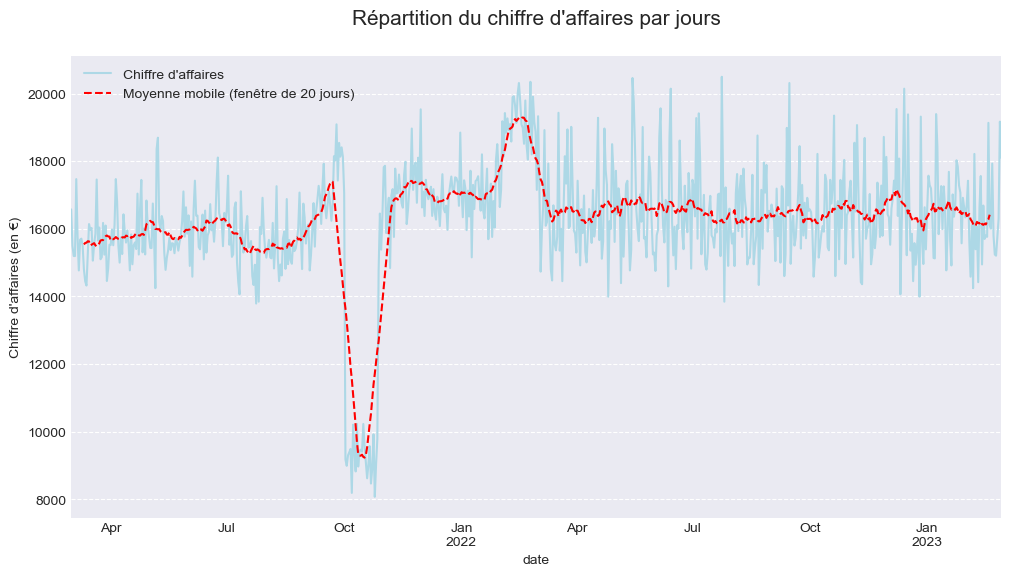

In [37]:
# Création d'un dataframe pour la somme du CA par jours
ca_jours = transactions_products_tempo['price'].resample('D').agg(['sum'])
ca_jours['Moyenne mobile'] = ca_jours['sum'].rolling(window=20, center=True).mean()

# Graphique
plt.figure(figsize=(12,6))
plt.title("Répartition du chiffre d'affaires par jours", fontsize=15, y=1.05)
ca_jours['sum'].plot(label="Chiffre d'affaires", color='lightblue')
ca_jours['Moyenne mobile'].plot(label='Moyenne mobile (fenêtre de 20 jours)', ls='--', color='red')
plt.ylabel("Chiffre d'affaires (en €)", fontsize=10)
plt.grid(axis='y', linestyle = 'dashed')
plt.legend()
plt.show()

In [38]:
# Chiffre d'affaires par mois et par catégorie
dict_categ = {}
for categ in transactions_products_tempo['categ'].unique():
    dict_categ[categ] = transactions_products_tempo.loc[transactions_products_tempo['categ'] == categ]['price'].resample('M').agg(['sum'])
    dict_categ[categ] = dict_categ[categ]['sum']
ca_categ_mois = pd.concat({k: pd.Series(v) for k, v in dict_categ.items()}).reset_index()
ca_categ_mois.columns = ['categ', 'date', "chiffre d'affaires"]
ca_categ_mois = ca_categ_mois.set_index('date')

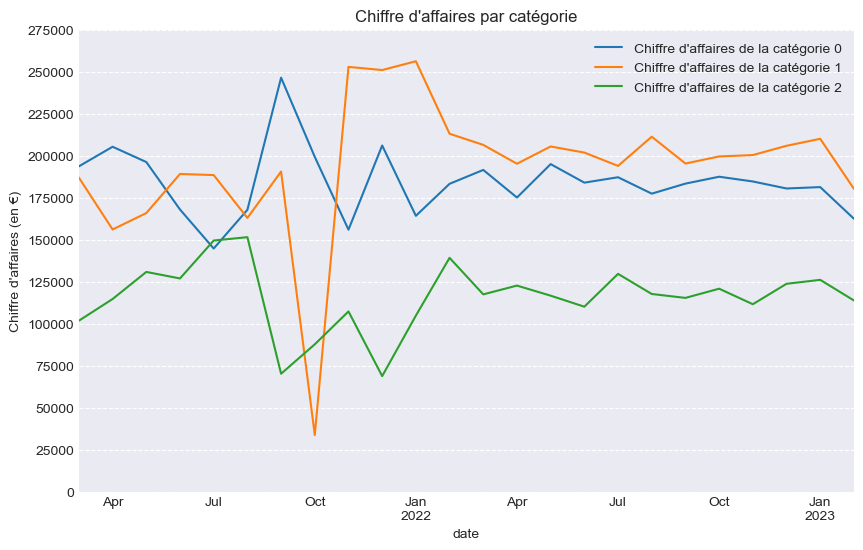

In [39]:
# Graphique chiffre d'affaires par catégorie
plt.figure(figsize=(10,6))
plt.title("Chiffre d'affaires par catégorie")
for categ in ca_categ_mois['categ'].unique():
    ca_categ_mois.loc[ca_categ_mois['categ'] == categ]["chiffre d'affaires"].plot(label=f"Chiffre d'affaires de la catégorie {int(categ)}")
plt.legend()
plt.ylabel("Chiffre d'affaires (en €)", fontsize=10)
plt.yticks(np.arange(0,300000,25000))
plt.grid(axis='y', linestyle = 'dashed')
plt.show()

In [40]:
# Affichons la moyenne du CA par catégorie
dict_categ = {}
for categ in transactions_products_tempo['categ'].unique():
    dict_categ[categ] = transactions_products_tempo.loc[transactions_products_tempo['categ'] == categ]['price'].resample('M').agg(['sum'])
    dict_categ[categ] = dict_categ[categ]['sum'].mean()
moy_ca_categ = pd.DataFrame(list(dict_categ.items())).rename(columns = {0 :'categ', 1 : 'Moyenne CA'})

# Affichons la moyenne du CA par catégorie pour le mois d'octobre 2021
dict_categ = {}
for categ in transactions_products_tempo['categ'].unique():
    dict_categ[categ] = transactions_products_tempo.loc[transactions_products_tempo['categ'] == categ]['price']['oct 2021'].resample('M').agg(['sum'])
    dict_categ[categ] = dict_categ[categ]['sum'].sum()
ca_octobre21 = pd.DataFrame(list(dict_categ.items())).rename(columns = {0 :'categ', 1 : 'CA octobre 2021'})

# Affichons les données pour comparaison avec le mois d'octobre 2021
df_recap = pd.merge(moy_ca_categ, ca_octobre21, on='categ', how='left')
df_recap['Différence en %'] = round((df_recap['CA octobre 2021'] - df_recap['Moyenne CA'])/df_recap['Moyenne CA']*100, 2)
df_recap

,categ,Moyenne CA,CA octobre 2021,Différence en %
0,0,184253.42,199325.30,8.18
1,1,193905.11,33762.32,-82.59
2,2,115844.79,87785.59,-24.22


### 3.3. Zoom sur les références  <a class="anchor" id="3_3"></a>

#### 3.3.1. Comparaison entre les références les plus vendues et les moins vendues  <a class="anchor" id="3_3_1"></a>

In [41]:
# Top 10 des références les plus vendues
ventes_ref = transactions_products[['categ','id_prod','price']].groupby(['categ','id_prod']).agg({'id_prod':'count', 'price':'sum'})
ventes_ref = ventes_ref.rename(columns={'id_prod':"Nombre d'achats",'price':"Chiffre d'affaires"}).sort_values(by="Nombre d'achats", ascending=False).reset_index()
ref_top = ventes_ref.head(10)
ref_top

,categ,id_prod,Nombre d'achats,Chiffre d'affaires
0,1,1_369,2252,54025.48
1,1,1_417,2189,45947.11
2,1,1_414,2180,51949.40
3,1,1_498,2128,49731.36
4,1,1_425,2096,35611.04
5,1,1_403,1960,35260.40
6,1,1_412,1951,32484.15
7,1,1_413,1945,34990.55
8,1,1_406,1939,48106.59
9,1,1_407,1935,30940.65


In [42]:
# Liste des 10 références les moins vendues
ref_flop = ventes_ref.tail(10)
ref_flop

,categ,id_prod,Nombre d'achats,Chiffre d'affaires
3256,0,0_2201,1,20.99
3257,0,0_1151,1,2.99
3258,0,0_1728,1,2.27
3259,2,2_81,1,86.99
3260,0,0_1539,1,0.99
3261,0,0_1284,1,1.38
3262,0,0_549,1,2.99
3263,0,0_1498,1,2.48
3264,0,0_541,1,1.99
3265,0,0_886,1,21.82


#### 3.3.2. Comparaison entre les références les plus vendues et les moins vendues (par catégorie) <a class="anchor" id="3_3_2"></a>

In [43]:
# Affichons les 10 références les plus vendues pour chaque catégorie
largest_ventes_categ = ventes_ref.loc[ventes_ref.groupby('categ')["Nombre d'achats"].nlargest(10).index.get_level_values(1)]
largest_ventes_categ = largest_ventes_categ.sort_values(by=['categ', "Nombre d'achats"], ascending=[True, False])

# Séparé par catégorie (faire avec display)
for categ in largest_ventes_categ['categ'].unique():
    print(f'Les 10 produits les plus vendus de la catégorie {int(categ)}')
    display(largest_ventes_categ.loc[largest_ventes_categ['categ'] == categ])
    print()

Les 10 produits les plus vendus de la catégorie 0


,categ,id_prod,Nombre d'achats,Chiffre d'affaires
50,0,0_1422,1292,14741.72
51,0,0_1431,1282,14089.18
53,0,0_1425,1266,16445.34
54,0,0_1432,1254,19261.44
58,0,0_1411,1246,11201.54
59,0,0_1428,1245,4419.75
61,0,0_0,1242,4657.50
62,0,0_1424,1238,10411.58
64,0,0_1441,1235,23452.65
65,0,0_1434,1235,10596.30



Les 10 produits les plus vendus de la catégorie 1


,categ,id_prod,Nombre d'achats,Chiffre d'affaires
0,1,1_369,2252,54025.48
1,1,1_417,2189,45947.11
2,1,1_414,2180,51949.40
3,1,1_498,2128,49731.36
4,1,1_425,2096,35611.04
5,1,1_403,1960,35260.40
6,1,1_412,1951,32484.15
7,1,1_413,1945,34990.55
8,1,1_406,1939,48106.59
9,1,1_407,1935,30940.65



Les 10 produits les plus vendus de la catégorie 2


,categ,id_prod,Nombre d'achats,Chiffre d'affaires
132,2,2_102,1027,60736.78
146,2,2_135,1005,69334.95
165,2,2_112,968,65407.76
186,2,2_39,915,53060.85
194,2,2_37,882,43209.18
205,2,2_110,865,53846.25
229,2,2_208,831,45596.97
236,2,2_209,814,56971.86
253,2,2_207,786,40078.14
271,2,2_109,744,40168.56


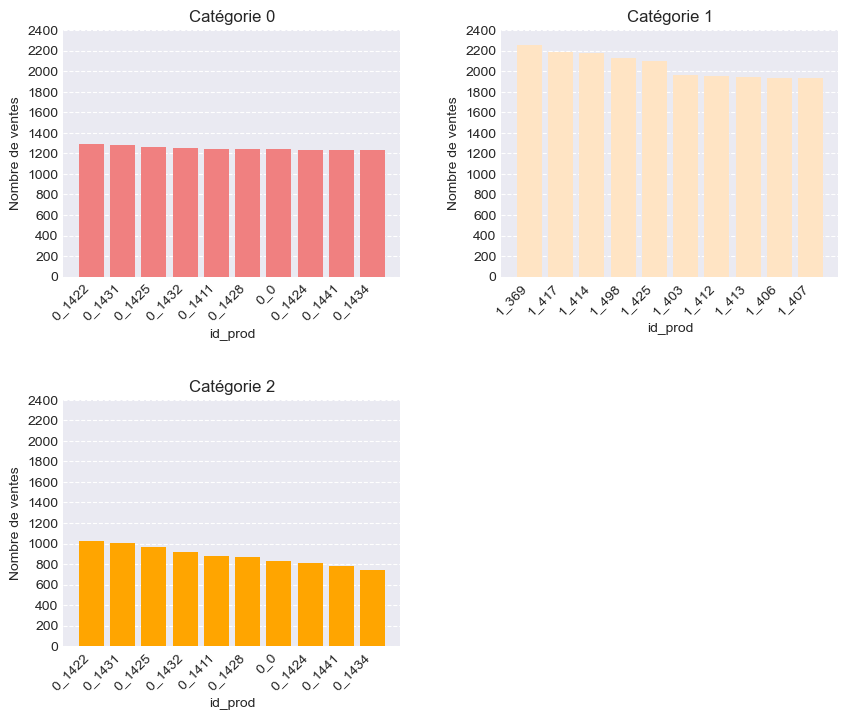

In [44]:
graphique_1 = plt.figure(figsize=(10,8))
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.subplot(2,2,1)
plt.bar(height=largest_ventes_categ.loc[largest_ventes_categ['categ'] == 0]["Nombre d'achats"], x=largest_ventes_categ.loc[largest_ventes_categ['categ'] == 0]['id_prod'], color='lightcoral')
plt.title('Catégorie 0')
plt.xlabel('id_prod', fontsize=10)
plt.ylabel('Nombre de ventes', fontsize=10)
plt.yticks(np.arange(0,2600,200))
plt.xticks(rotation = 45, ha='right')
plt.grid(axis='y', linestyle = 'dashed')
plt.subplot(2,2,2)
plt.bar(height=largest_ventes_categ.loc[largest_ventes_categ['categ'] == 1]["Nombre d'achats"], x=largest_ventes_categ.loc[largest_ventes_categ['categ'] == 1]['id_prod'], color='bisque')
plt.title('Catégorie 1')
plt.xlabel('id_prod', fontsize=10)
plt.ylabel('Nombre de ventes', fontsize=10)
plt.yticks(np.arange(0,2600,200))
plt.xticks(rotation = 45, ha='right')
plt.grid(axis='y', linestyle = 'dashed')
plt.subplot(2,2,3)
plt.bar(height=largest_ventes_categ.loc[largest_ventes_categ['categ'] == 2]["Nombre d'achats"], x=largest_ventes_categ.loc[largest_ventes_categ['categ'] == 0]['id_prod'], color='orange')
plt.title('Catégorie 2')
plt.xlabel('id_prod', fontsize=10)
plt.ylabel('Nombre de ventes', fontsize=10)
plt.yticks(np.arange(0,2600,200))
plt.xticks(rotation = 45, ha='right')
plt.grid(axis='y', linestyle = 'dashed')
plt.show()

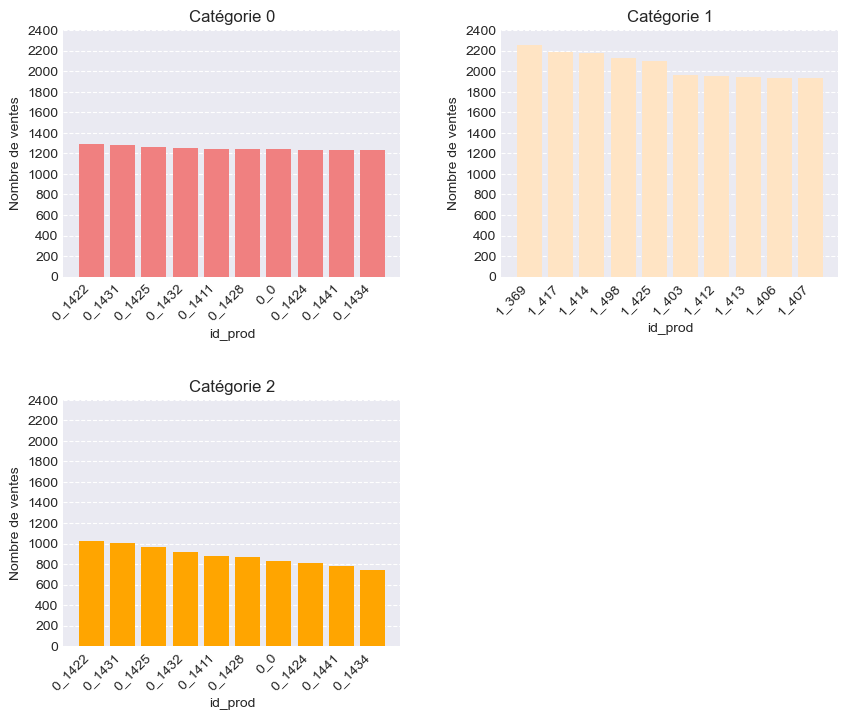

In [45]:
# Produits les plus vendus
graphique_1

In [46]:
# Affichons les 10 références les moins vendues pour chaque catégorie
smallest_ventes_categ = ventes_ref.loc[ventes_ref.groupby('categ')["Nombre d'achats"].nsmallest(10).index.get_level_values(1)]
smallest_ventes_categ = smallest_ventes_categ.sort_values(by=['categ', "Nombre d'achats"], ascending=[True, False])

# Séparé par catégorie
for categ in smallest_ventes_categ['categ'].unique():
    print(f'Les 10 produits les moins vendus de la catégorie {int(categ)}')
    display(smallest_ventes_categ.loc[smallest_ventes_categ['categ'] == categ])
    print()

Les 10 produits les moins vendus de la catégorie 0


,categ,id_prod,Nombre d'achats,Chiffre d'affaires
3250,0,0_1379,1,2.99
3251,0,0_1601,1,1.99
3252,0,0_833,1,2.99
3253,0,0_1633,1,24.99
3254,0,0_1683,1,2.99
3255,0,0_807,1,1.99
3256,0,0_2201,1,20.99
3257,0,0_1151,1,2.99
3258,0,0_1728,1,2.27
3260,0,0_1539,1,0.99



Les 10 produits les moins vendus de la catégorie 1


,categ,id_prod,Nombre d'achats,Chiffre d'affaires
3142,1,1_411,4,131.96
3146,1,1_470,4,21.64
3149,1,1_485,4,151.96
3200,1,1_408,3,105.72
3202,1,1_404,3,29.55
3212,1,1_146,3,95.94
3214,1,1_409,3,167.97
3229,1,1_514,2,135.32
3244,1,1_420,2,14.24
3247,1,1_402,2,69.04



Les 10 produits les moins vendus de la catégorie 2


,categ,id_prod,Nombre d'achats,Chiffre d'affaires
3179,2,2_66,3,452.16
3191,2,2_78,3,502.47
3218,2,2_28,3,310.50
3219,2,2_130,3,427.74
3220,2,2_131,3,383.97
3224,2,2_77,2,291.98
3234,2,2_93,2,157.98
3248,2,2_98,1,149.74
3249,2,2_23,1,115.99
3259,2,2_81,1,86.99


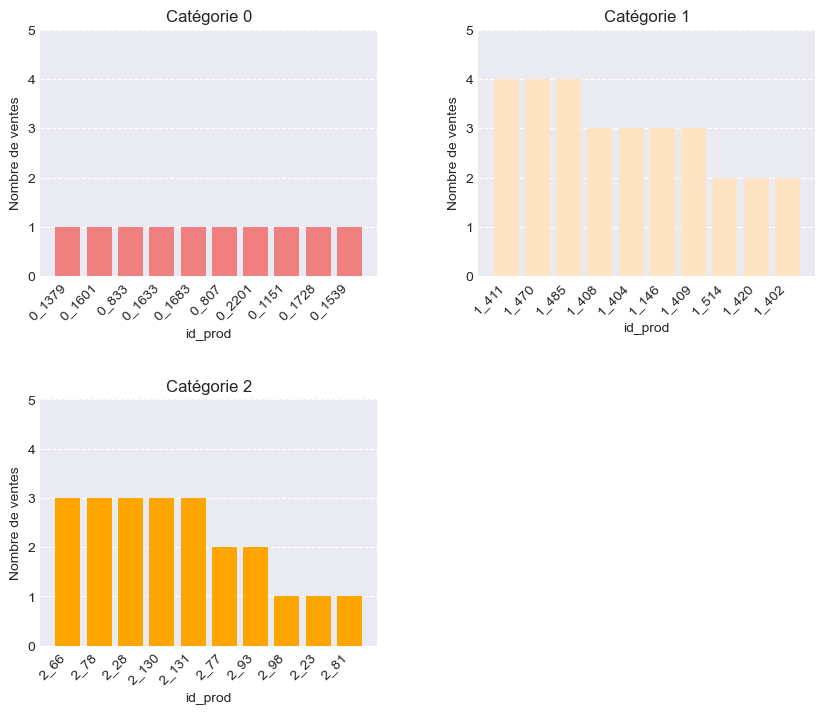

In [47]:
graphique_2 = plt.figure(figsize=(10,8))
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.subplot(2,2,1)
plt.bar(height=smallest_ventes_categ.loc[smallest_ventes_categ['categ'] == 0]["Nombre d'achats"], x=smallest_ventes_categ.loc[smallest_ventes_categ['categ'] == 0]['id_prod'], color='lightcoral')
plt.title('Catégorie 0')
plt.xlabel('id_prod', fontsize=10)
plt.ylabel('Nombre de ventes', fontsize=10)
plt.yticks(np.arange(0,6,1))
plt.xticks(rotation = 45, ha='right')
plt.grid(axis='y', linestyle = 'dashed')
plt.subplot(2,2,2)
plt.bar(height=smallest_ventes_categ.loc[smallest_ventes_categ['categ'] == 1]["Nombre d'achats"], x=smallest_ventes_categ.loc[smallest_ventes_categ['categ'] == 1]['id_prod'], color='bisque')
plt.title('Catégorie 1')
plt.xlabel('id_prod', fontsize=10)
plt.ylabel('Nombre de ventes', fontsize=10)
plt.yticks(np.arange(0,6,1))
plt.xticks(rotation = 45, ha='right')
plt.grid(axis='y', linestyle = 'dashed')
plt.subplot(2,2,3)
plt.bar(height=smallest_ventes_categ.loc[smallest_ventes_categ['categ'] == 2]["Nombre d'achats"], x=smallest_ventes_categ.loc[smallest_ventes_categ['categ'] == 2]['id_prod'], color='orange')
plt.title('Catégorie 2')
plt.xlabel('id_prod', fontsize=10)
plt.ylabel('Nombre de ventes', fontsize=10)
plt.yticks(np.arange(0,6,1))
plt.xticks(rotation = 45, ha='right')
plt.grid(axis='y', linestyle = 'dashed')
plt.show()

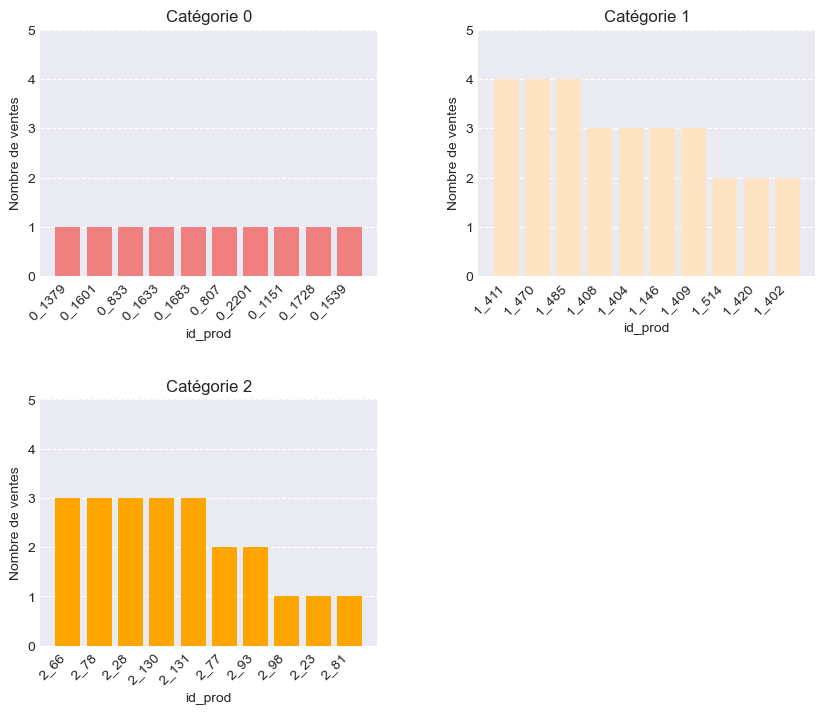

In [48]:
# Produits les moins vendus
graphique_2

### 3.4. Profils des clients  <a class="anchor" id="3_4"></a>

In [49]:
# Jointure avec les données clients
transactions_products_customers = pd.merge(transactions_products, customers, how='left', on='client_id')

# CA cumulé par client
ca_cumulé = transactions_products_customers[['client_id','price']].groupby(['client_id']).sum().reset_index()
ca_cumulé = ca_cumulé.rename(columns={'price':'CA cumulé'})

In [50]:
# Afficher la courbe de Lorenz
n = len(ca_cumulé['CA cumulé'])
lorenz = np.cumsum(np.sort(ca_cumulé['CA cumulé']))/ ca_cumulé['CA cumulé'].sum()
lorenz = np.append([0], lorenz)

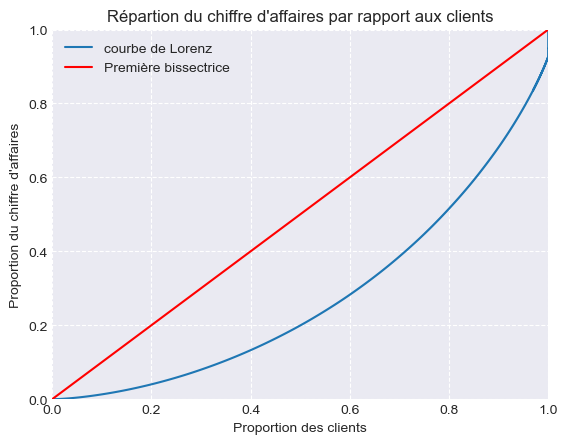

In [51]:
xaxis = np.linspace(0-1/n,1+1/n,n+1) #Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0. Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.
plt.figure()
plt.title("Répartion du chiffre d'affaires par rapport aux clients")
plt.plot(xaxis,lorenz,drawstyle='steps-post', label='courbe de Lorenz')
plt.plot([0, 1], [0, 1], color='red', label='Première bissectrice') # Ajout de la première bissectrice
plt.xlabel('Proportion des clients', fontsize=10)
plt.ylabel("Proportion du chiffre d'affaires", fontsize=10)
plt.legend()
plt.xlim(0,1)
plt.ylim(0,1)
plt.grid(linestyle = 'dashed')
plt.show()

In [52]:
AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
gini = 2*S

print("L'indice de Gini est de :", round(gini,2))

L'indice de Gini est de : 0.45


Un indice de Gini de 0.45 veut dire que la répartition du chiffre d'affaires est inégale, mais pas de manière extrême. Certains clients générent une part plus importante du chiffre d'affaires.

Regardons de plus près le chiffre d'affaires des clients afin d'identifier de potentiels acheteurs importants. 

### 3.5. Clients outliers  <a class="anchor" id="3_5"></a>

In [53]:
# Regardons de plus près les CA cumulés pour indentifier les gros consommateurs
df_describe = ca_cumulé.describe()
df_describe

,CA cumulé
count,8600.00
mean,1378.61
std,5182.88
min,6.31
25%,547.88
50%,1027.21
75%,1779.78
max,324033.35


Il y a 75% des acheteurs qui cumulent moins de 1780€ de chiffre d'affaires. Pour autant, le maximum de chiffre d'affaires cumulé est de plus de 324 000€. 

Il y a donc une grande disparité entre le chiffre d'affaires cumulé maximum et le reste.  

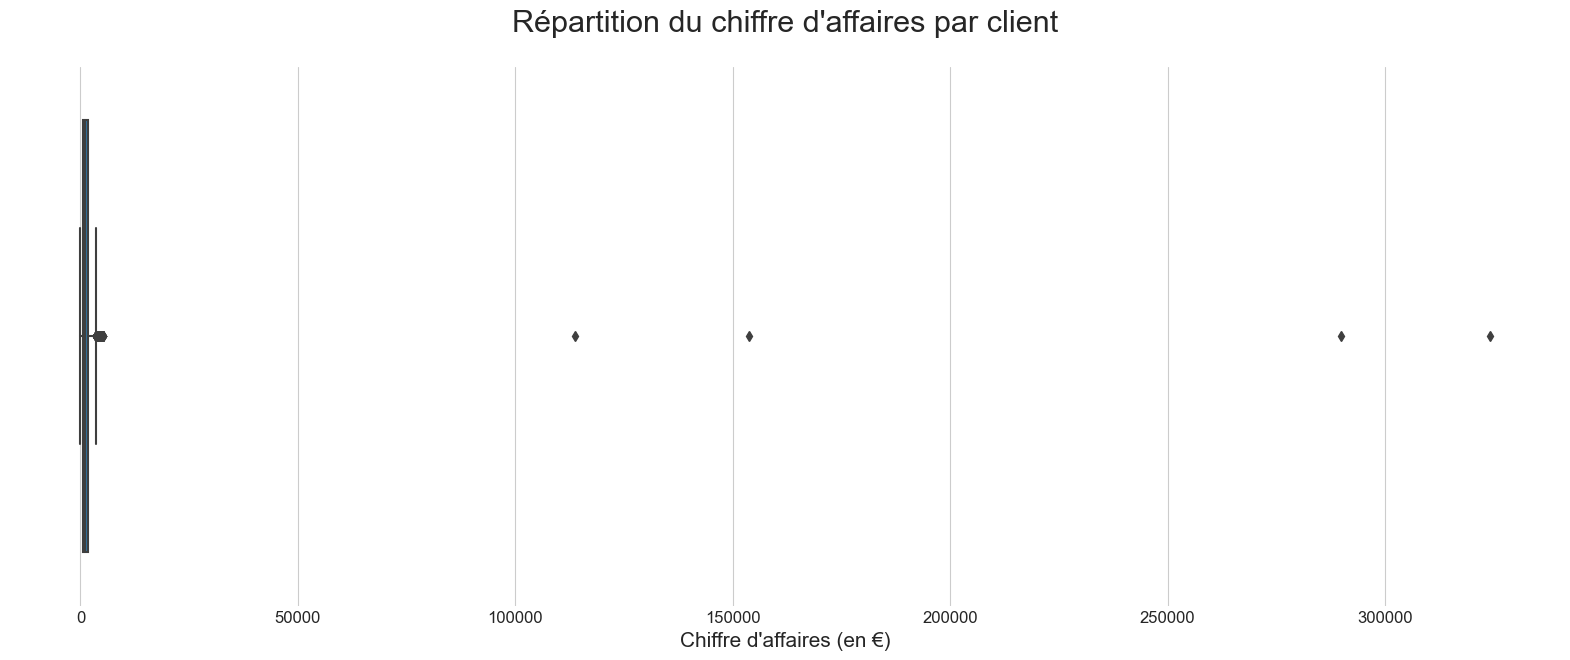

In [54]:
# Utilisons une boxplot pour visualiser cela
plt.figure(figsize=(20,7))
sns.set_style('whitegrid')
sns.boxplot(x=ca_cumulé['CA cumulé'])
plt.title("Répartition du chiffre d'affaires par client", fontsize=22, y=1.05)
plt.xlabel("Chiffre d'affaires (en €)", fontsize=15)
plt.tick_params(labelsize=12)
plt.show()

Nous pouvons voir qu'il y a 4 clients qui génèrent plus de 100 000€ de chiffre d'affaires cumulé. Nous les identifierons comme clients professionnels et nous allons les exclure afin qu'ils ne faussent pas le reste de l'analyse. 

In [55]:
# Création d'une liste de clients professionnels
liste_clients_pro = ca_cumulé.loc[ca_cumulé['CA cumulé'] > 100000]['client_id'].unique()
liste_clients_pro

array(['c_1609', 'c_3454', 'c_4958', 'c_6714'], dtype=object)

In [56]:
# Supprimons les clients professionnels de la liste du dataframe réunissant toutes les informations 
transactions_products_customers = transactions_products_customers[~transactions_products_customers['client_id'].isin(liste_clients_pro)]

## 4. Etude des différentes corrélations <a class="anchor" id="4"></a>

### 4.1. Lien entre le genre d'un client et les catégories des livres achetés  <a class="anchor" id="4_1"></a>

Testons l'indépendance statistique entre ces deux variables aléatoire dicrètes avec un test du Chi-2 : 
- H0 = L'achat de livre par rapport à la catégorie est indépendant du genre du client
- H1 = L'achat de livre par rapport à la catégorie est associé au genre du client

Seuil de significativité : 5%

In [57]:
# Renommer la colonne sex et ses variables pour plus de lisibilité
transactions_products_customers = transactions_products_customers.rename(columns={'sex': 'Genre'})
transactions_products_customers['Genre'] = transactions_products_customers['Genre'].map({'f': 'femme', 'm':'homme'})

# Regroupons les variables dans un tableau de contingence
table_genre_catégorie = pd.crosstab(transactions_products_customers['Genre'], transactions_products_customers['categ'])
table_genre_catégorie                   

categ,0,1,2
Genre,,,
femme,200904,111331,16980
homme,186589,101017,15868


In [58]:
# Test du Chi-2
stat, p_value, dof, expected = stats.chi2_contingency(table_genre_catégorie)

# Résultat
print('Statistique de test du chi2 : ', stat)
print('p-valeur : ', p_value)
print() # Insertion d'une ligne vide (espace)

# Interprétation 
seuil_significativité = 0.05
if p_value > seuil_significativité:
    print("L'achat de livre en fonction de la catégorie n'est pas associé au genre du client.\nNous ne pouvons pas rejeter l'hypothèse H0.")
else:
    print("L'achat de livre en fonction de la catégorie est associé au genre du client.\nNous pouvons rejetter l'hypothèse H0.")

Statistique de test du chi2 :  20.200173796862927
p-valeur :  4.1075985631484716e-05

L'achat de livre en fonction de la catégorie est associé au genre du client.
Nous pouvons rejetter l'hypothèse H0.


Nous allons maintenant mesurer la force de la relation entre les variables 'genre' et 'catégorie'.

Pour cela, nous allons calculer le coefficient de contingence de Cramer avec les données du Chi-2 ci-dessus : 

In [59]:
# Calculons le coefficient de contingence de Cramer, nous utiliserons le résultat de la statistique de test du Chi2 et son degrès de liberté
coef_cramer = np.sqrt(stat / (len(transactions_products_customers) * (dof-1)))

# Résultat
print('Coefficient de contingence de Cramer : ', coef_cramer)

# Interprétation
if coef_cramer < 0.1:
    print('La relation entre les deux variables est nulle ou très faible.')
elif (coef_cramer >= 0.1) & (coef_cramer < 0.2):
    print('La relation entre les deux variables est faible.')
elif (coef_cramer >= 0.2) & (coef_cramer < 0.3):
    print('La relation entre les deux variables est moyenne.')
elif coef_cramer >= 0.3:
    print('La relation entre les deux variables est forte.')

Coefficient de contingence de Cramer :  0.0056504418660519575
La relation entre les deux variables est nulle ou très faible.


### 4.2. Lien entre l'âge des clients et ...  <a class="anchor" id="4_2"></a>

In [60]:
# Calculons l'âge des clients en fonction de la date de naissance
import datetime
annee_actuelle = datetime.datetime.now().year
transactions_products_customers['age'] = annee_actuelle - transactions_products_customers['birth']

In [61]:
# Il faut maintenant créer des intervalles pour les interprétations à venir 
def categorie_ages(age):
    if age <=30:
        return '-30 ans'
    elif (age > 30) & (age <= 50):
        return '30-50 ans'
    elif age > 50:
        return '+50 ans'
    
transactions_products_customers['tranche age'] = transactions_products_customers['age'].map(categorie_ages)
ordre_categ_age = ['-30 ans', '30-50 ans', '+50 ans']
transactions_products_customers['tranche age'] = pd.Categorical(transactions_products_customers['tranche age'], categories=ordre_categ_age, ordered=True)

#### 4.2.1. ... le montant total des achats <a class="anchor" id="4_2_1"></a>

In [62]:
# Calculons le montant total des achats par clients
montant_achats = transactions_products_customers.groupby('client_id')['price'].sum().reset_index().rename(columns={'price':'Montant total des achats'})

# Jointure des résultats trouvés avec transactions_products_customers
transactions_products_customers = pd.merge(transactions_products_customers, montant_achats, on='client_id', how='left')

Vérifions la répartion du montant total des achats en fonction du genre et de la catégorie des livres achetés. 

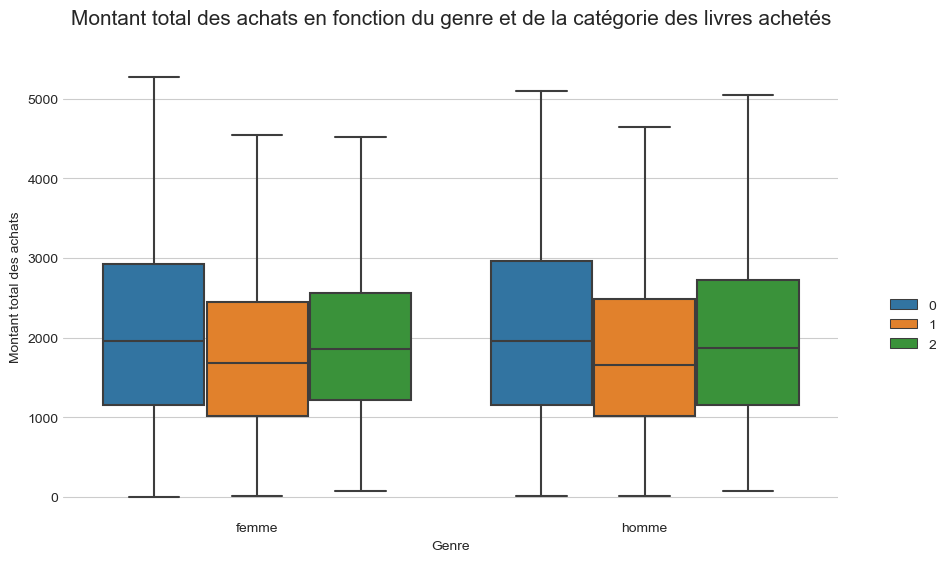

In [63]:
# Montant total des achats par genre et par catégorie
plt.figure(figsize=(10,6))
sns.boxplot(x= 'Genre', y='Montant total des achats', hue='categ', data = transactions_products_customers, showfliers=False)
plt.title("Montant total des achats en fonction du genre et de la catégorie des livres achetés", fontsize=15, y=1.05)
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='upper left')
plt.show()

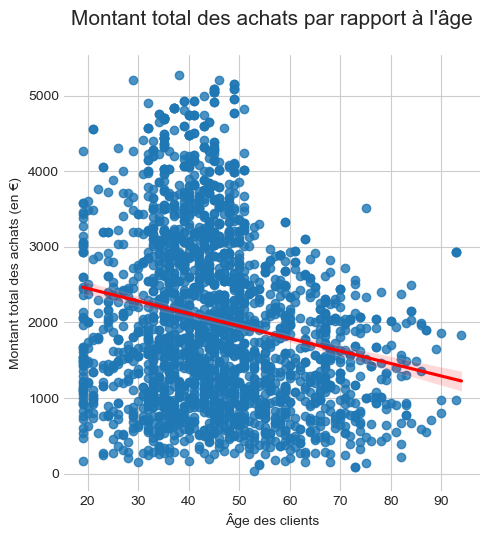

In [64]:
# Affichons un nuage de point
sns.lmplot(x='age', y='Montant total des achats', data=transactions_products_customers.sample(2500), line_kws={'color': 'red'})
plt.title("Montant total des achats par rapport à l'âge", fontsize=15, y=1.05)
plt.xlabel('Âge des clients')
plt.ylabel('Montant total des achats (en €)')
plt.show()

Il y a visiblement une faible corrélation négative entre le montant des achats et l'âge.

Pour voir s'il y a réellement une corrélation entre ces deux variables, nous pourrions utiliser un test de Pearson.
Mais avant cela, nous allons voir la distribution des variables "âge" et "Montant des achats". 

Testons si les variables suivent une loi Normale. Prenons les hypothèses suivantes : 
- H0 : La variable suit une loi Normale ; 
- H1 : La variable ne suit pas une loi Normale

Seuil de significativité : 5%

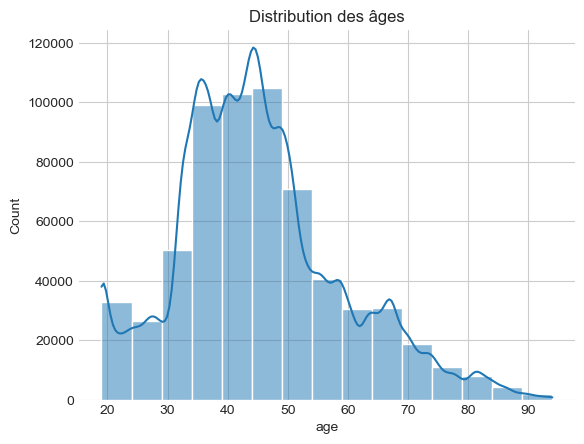

In [65]:
# Histogramme de la variable âge
sns.histplot(transactions_products_customers['age'], bins = 15, kde=True)
plt.title('Distribution des âges')
plt.show()

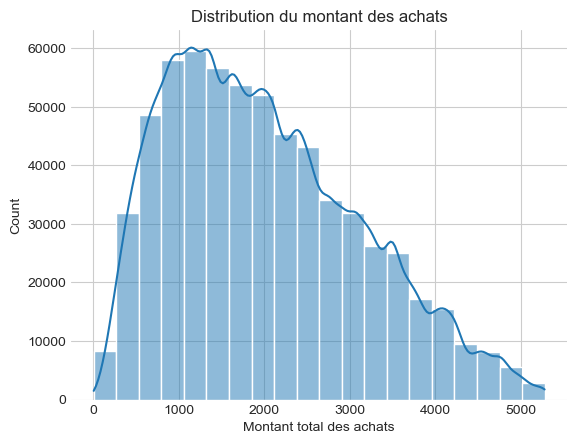

In [66]:
# Histogramme de la variable Montant des achats
sns.histplot(transactions_products_customers['Montant total des achats'], bins = 20, kde=True)
plt.title('Distribution du montant des achats')
plt.show()

Les deux distributions ne suivent probablement pas une loi Normale. Testons : 

In [67]:
# Test de normalité de Shapiro-wilk pour l'age
stat, p = stats.shapiro(transactions_products_customers['age'])

# Résultat
print("Statistique de test de Shapiro-Wilk : ", stat)
print("p-valeur : ", p)
print() # Insertion d'une ligne vide (espace)

# Interprétation 
seuil_significativité = 0.05
if p > seuil_significativité:
    print("La distribution de la variable 'age' ne diffère pas significativement d'une distribution normale.\nNous ne pouvons pas rejeter l'hypothèse H0.")
else:
    print("La distribution de la variable 'age' diffère significativement d'une distribution normale.\nNous pouvons rejetter l'hypothèse H0.")

Statistique de test de Shapiro-Wilk :  0.9709893465042114
p-valeur :  0.0

La distribution de la variable 'age' diffère significativement d'une distribution normale.
Nous pouvons rejetter l'hypothèse H0.


In [68]:
# Test de normalité de Shapiro-wilk pour le montant des achats
stat, p = stats.shapiro(transactions_products_customers['Montant total des achats'])

# Résultat
print("Statistique de test de Shapiro-Wilk : ", stat)
print("p-valeur : ", p)
print() # Insertion d'une ligne vide (espace)

# Interprétation 
seuil_significativité = 0.05
if p > seuil_significativité:
    print("La distribution de la variable 'Montant total des achats' ne diffère pas significativement d'une distribution normale.\nNous ne pouvons pas rejeter l'hypothèse H0.")
else:
    print("La distribution de la variable 'Montant total des achats' diffère significativement d'une distribution normale.\nNous pouvons rejetter l'hypothèse H0.")

Statistique de test de Shapiro-Wilk :  0.9637722969055176
p-valeur :  0.0

La distribution de la variable 'Montant total des achats' diffère significativement d'une distribution normale.
Nous pouvons rejetter l'hypothèse H0.


Nous allons donc utiliser un test non-paramétrique : calcul du coefficient de Spearman. 

Supposons : 
- H0 : le montant des achats n'est pas corrélé à l'âge des clients ;
- H1 : le montant des achats est corrélé à l'âge des clients.

Seuil de significativité : 5%

In [69]:
# Calculons le coefficient de Spearman
corr, p_value = stats.spearmanr(transactions_products_customers['Montant total des achats'], transactions_products_customers['age'])

#Résultat
print("Coefficient de corrélation de Spearman : ", corr)
print("p-valeur : ", p_value)
print()

# Interprétation 
seuil_significativité = 0.05
if p_value > seuil_significativité:
    print("Il n'y a pas suffisamment de preuves pour conclure à une corrélation significative entre les variables.")
else:
    if corr > 0:
        print("Il y a une corrélation positive significative entre les deux variables.")
    elif corr < 0:
        print("Il y a une corrélation négative significative entre les deux variables.")
    else:
        print("Le coefficient de corrélation est nulle. Il n'existe pas de relation significative entre les deux variables.")

Coefficient de corrélation de Spearman :  -0.2060508796365274
p-valeur :  0.0

Il y a une corrélation négative significative entre les deux variables.


#### 4.2.2. ... la fréquence des achats <a class="anchor" id="4_2_2"></a>

In [70]:
# Caculons le nombre de jours 
nb_jours = (transactions_products_customers['date'].max() - transactions_products_customers['date'].min()).days

# Calculons la fréquence d'achat par client
fréquence_achats = transactions_products_customers.groupby('client_id')['id_prod'].count().reset_index()
fréquence_achats = fréquence_achats.rename(columns={'id_prod':"Fréquence d'achat"})
fréquence_achats["Fréquence d'achat"] = fréquence_achats["Fréquence d'achat"]/nb_jours

# Jointure avec transactions_products_customers
transactions_products_customers = pd.merge(transactions_products_customers, fréquence_achats, on='client_id', how='left')

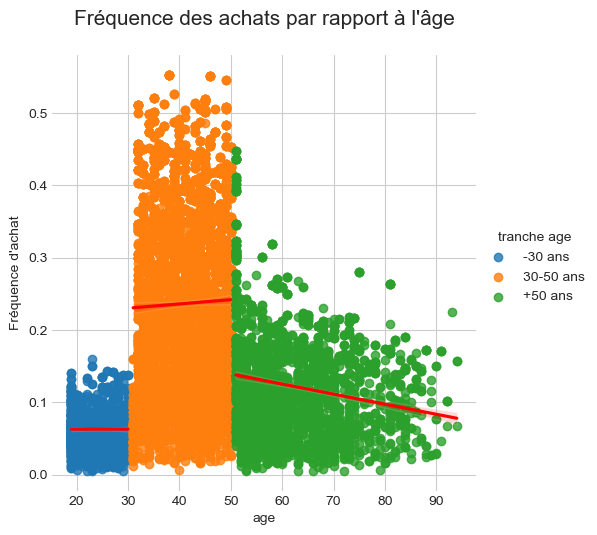

In [71]:
# Affichons un nuage de point
sns.lmplot(x='age', y="Fréquence d'achat", hue='tranche age', data=transactions_products_customers.sample(10000), line_kws={'color': 'red'})
plt.title("Fréquence des achats par rapport à l'âge", fontsize=15, y=1.05)
plt.show()

Pour voir s'il y a réellement une corrélation entre ces deux variables, nous allons utiliser un test de Pearson.
Mais avant cela, nous allons voir la distribution de la variable "Fréquence d'achat". 

Testons si cette variable suit une loi Normale. Prenons les hypothèses suivantes : 
- H0 : La variable suit une loi Normale ; 
- H1 : La variable ne suit pas une loi Normale

Seuil de significativité : 5%

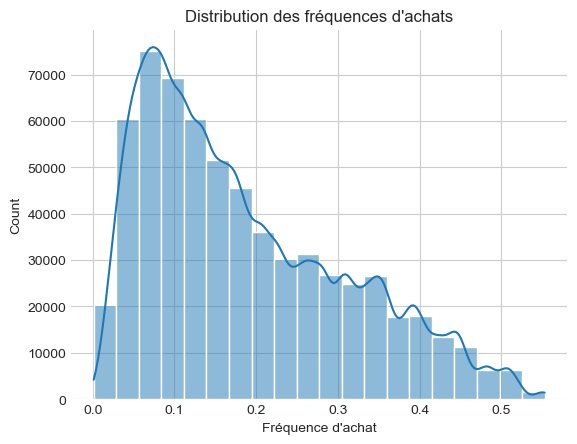

In [72]:
# Histogramme de la variable Fréquence d'achat
sns.histplot(transactions_products_customers["Fréquence d'achat"], bins = 20, kde=True)
plt.title("Distribution des fréquences d'achats")
plt.show()

La distribution des fréquences d'achat ne suit probablement pas une loi normale.

In [73]:
# Test de normalité de Shapiro-wilk pour la fréquence d'achat
stat, p = stats.shapiro(transactions_products_customers["Fréquence d'achat"])

# Résultat
print("Statistique de test de Shapiro-Wilk : ", stat)
print("p-valeur : ", p)
print() # Insertion d'une ligne vide (espace)

# Interprétation 
seuil_significativité = 0.05
if p > seuil_significativité:
    print("La distribution de la variable 'Fréquence d'achat' ne diffère pas significativement d'une distribution normale.\nNous ne pouvons pas rejeter l'hypothèse H0.")
else:
    print("La distribution de la variable 'Fréquence d'achat' diffère significativement d'une distribution normale.\nNous pouvons rejetter l'hypothèse H0.")

Statistique de test de Shapiro-Wilk :  0.930072546005249
p-valeur :  0.0

La distribution de la variable 'Fréquence d'achat' diffère significativement d'une distribution normale.
Nous pouvons rejetter l'hypothèse H0.


Nous allons donc utiliser un test non-paramétrique : calcul du coefficient de Spearman. 

Supposons : 
- H0 : la fréquence des achats n'est pas corrélé à l'âge des clients ;
- H1 : la fréquence des achats est corrélé à l'âge des clients.

Seuil de significativité : 5%

In [74]:
# Calculons le coefficient de Spearman
corr, p_value = stats.spearmanr(transactions_products_customers["Fréquence d'achat"], transactions_products_customers['age'])

#Résultat
print("Coefficient de corrélation de Spearman : ", corr)
print("p-valeur : ", p_value)
print()

# Interprétation 
seuil_significativité = 0.05
if p_value > seuil_significativité:
    print("Il n'y a pas suffisamment de preuves pour conclure à une corrélation significative entre les variables.")
else:
    if corr > 0:
        print("Il y a une corrélation positive significative entre les deux variables.")
    elif corr < 0:
        print("Il y a une corrélation négative significative entre les deux variables.")
    else:
        print("Le coefficient de corrélation est nulle. Il n'existe pas de relation significative entre les deux variables.")

Coefficient de corrélation de Spearman :  -0.054392894340325404
p-valeur :  0.0

Il y a une corrélation négative significative entre les deux variables.


#### 4.2.3. ... la taille du panier moyen <a class="anchor" id="4_2_3"></a>

In [75]:
# Calculons le panier moyen par client
panier_moyen = transactions_products_customers.groupby('client_id')['price'].mean().reset_index().rename(columns={'price':'panier moyen'})

# Jointure avec transactions_products_customers
transactions_products_customers = pd.merge(transactions_products_customers, panier_moyen, on='client_id', how='left')

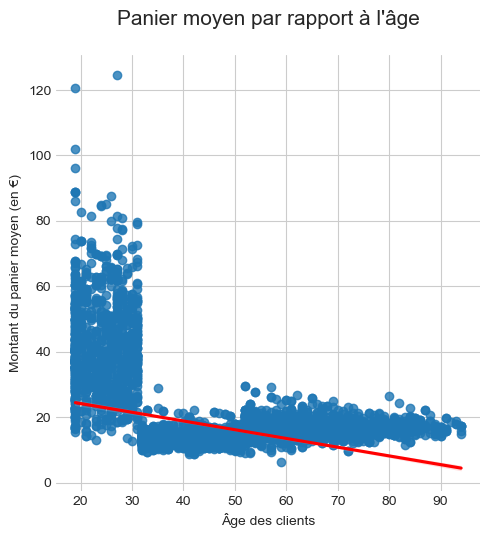

In [76]:
# Affichons un nuage de point
sns.lmplot(x='age', y='panier moyen', data=transactions_products_customers.sample(10000), line_kws={'color': 'red'})
plt.title("Panier moyen par rapport à l'âge", fontsize=15, y=1.05)
plt.xlabel('Âge des clients')
plt.ylabel('Montant du panier moyen (en €)')
plt.show()

Nous pouvons constater qu'il y a deux tranches d'âge nettement distinctes ici : 
- les moins de 30 ans d'un côté, 
- et les plus de 30 ans de l'autre. 

Pour affiner cela, nous pourrions créer deux groupes d'âge distincts.

In [77]:
# Création des 2 tranches d'âge
def categorie_ages(age):
    if age <=30:
        return '-30 ans'
    elif age > 30:
        return '+30 ans'
    
transactions_products_customers['tranche age_2'] = transactions_products_customers['age'].map(categorie_ages)
ordre_categ_age = ['-30 ans', '+30 ans']
transactions_products_customers['tranche age_2'] = pd.Categorical(transactions_products_customers['tranche age_2'], categories=ordre_categ_age, ordered=True)

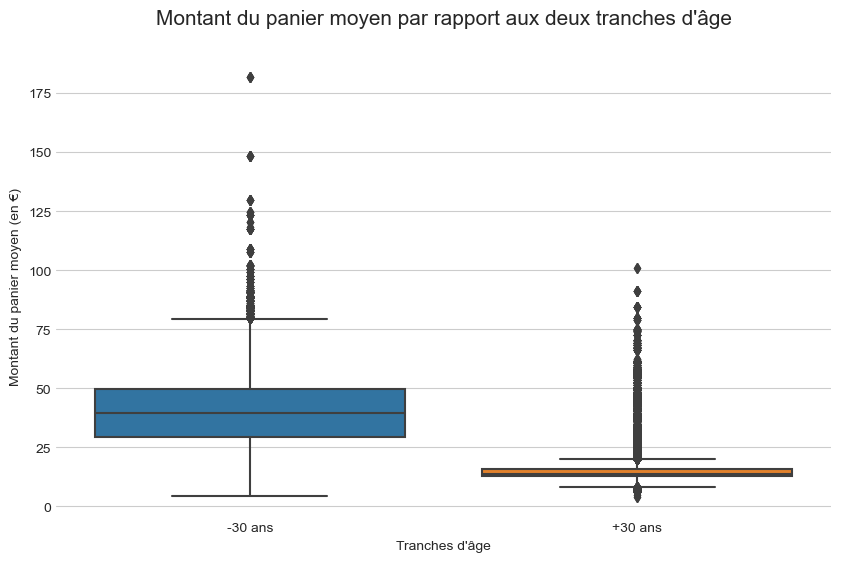

In [78]:
# Affichons cela sur une boîte à moustache
plt.figure(figsize=(10,6))
sns.boxplot(x='tranche age_2', y='panier moyen', data=transactions_products_customers)
plt.title("Montant du panier moyen par rapport aux deux tranches d'âge", fontsize=15, y=1.05)
plt.xlabel("Tranches d'âge")
plt.ylabel('Montant du panier moyen (en €)')
plt.show()

Nous pourrions maintenant isoler les outliers sur ces deux tranches d'âge afin de ne pas prendre en compte les valeurs extrêmes dans la suite de l'analyse.

In [79]:
# Nouveau dataframe pour les moins de 30 ans
moins_30 = transactions_products_customers.loc[transactions_products_customers['tranche age_2'] == '-30 ans']

# Calculons le premier quartile et le troisième quartile pour les moins de 30 ans
Q1_moins30 = moins_30['panier moyen'].quantile(0.25)
Q3_moins30 = moins_30['panier moyen'].quantile(0.75)

# Calculons IQR pour les moins de 30 ans
IQR_moins30 = Q3_moins30 - Q1_moins30

# Calculons la borne inférieure et supérieure pour les moins de 30 ans
borne_inférieure_moins30 = Q1_moins30-1.5*IQR_moins30
borne_supérieure_moins30 = Q3_moins30+1.5*IQR_moins30

# Enlevons les outliers du dataframe des moins de 30 ans
moins_30 = moins_30[(moins_30['panier moyen'] >= borne_inférieure_moins30) & (moins_30['panier moyen'] <=borne_supérieure_moins30)]

In [80]:
# Nouveau dataframe pour les plus de 30 ans
plus_30 = transactions_products_customers.loc[transactions_products_customers['tranche age_2'] == '+30 ans']

# Calculons le premier quartile et le troisième quartile pour les plus de 30 ans
Q1_plus30 = plus_30['panier moyen'].quantile(0.25)
Q3_plus30 = plus_30['panier moyen'].quantile(0.75)

# Calculons IQR pour les plus de 30 ans
IQR_plus30 = Q3_plus30 - Q1_plus30

# Calculons la borne inférieure et supérieure pour les plus de 30 ans
borne_inférieure_plus30 = Q1_plus30-1.5*IQR_plus30
borne_supérieure_plus30 = Q3_plus30+1.5*IQR_plus30

# Enlevons les outliers du dataframe des plus de 30 ans
plus_30 = plus_30[(plus_30['panier moyen'] >= borne_inférieure_plus30) & (plus_30['panier moyen'] <=borne_supérieure_plus30)]

Pour utiliser le test de Student, certaines conditions doivent être respectées comme : 
  - les échantillons doivent suivre une loi normale, 
  - les variances doivent être égales.

Regardons si nos deux échantillons suivent une loi normale.

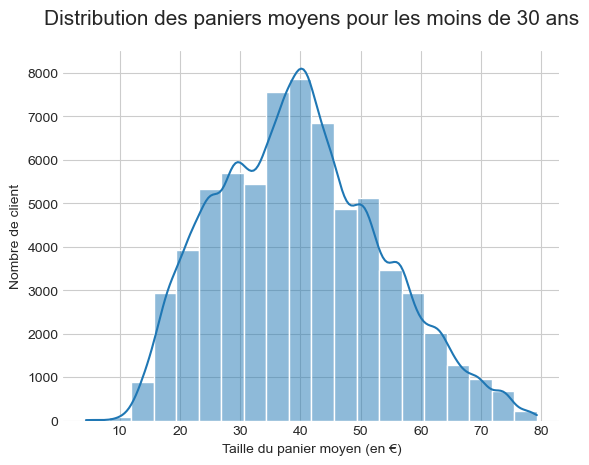

In [81]:
# Affichons l'histograme des paniers moyens des -30 ans
sns.histplot(x='panier moyen', data=moins_30, bins = 20, kde=True)
plt.title('Distribution des paniers moyens pour les moins de 30 ans', fontsize=15, y=1.05)
plt.xlabel('Taille du panier moyen (en €)')
plt.ylabel('Nombre de client')
plt.show()

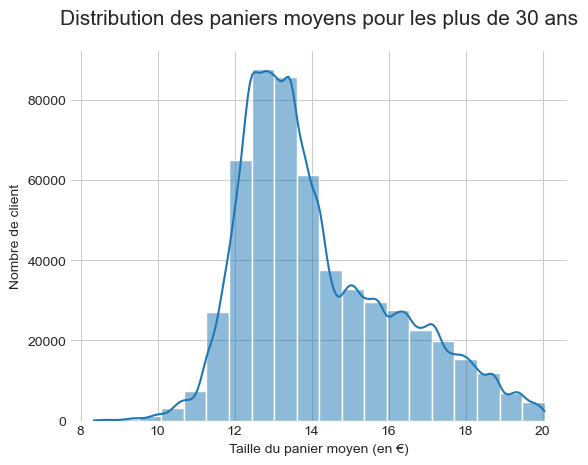

In [82]:
# Affichons l'histograme des paniers moyens des +30 ans
sns.histplot(x='panier moyen', data=plus_30, bins = 20, kde=True)
plt.title('Distribution des paniers moyens pour les plus de 30 ans', fontsize=15, y=1.05)
plt.xlabel('Taille du panier moyen (en €)')
plt.ylabel('Nombre de client')
plt.show()

La distribution des paniers moyens pour nos deux tranches d'âge semblent ce raprocher d'une loi normale.

Utilisons le test de Shapiro-wilk :
- H0 : La variable suit une loi Normale ; 
- H1 : La variable ne suit pas une loi Normale

Seuil de significativité : 5%

In [83]:
# Test de normalité de Shapiro-wilk pour la la variable 'panier moyen' pour les moins de 30 ans
stat, p = stats.shapiro(moins_30['panier moyen'])

# Résultat
print("Statistique de test de Shapiro-Wilk : ", stat)
print("p-valeur : ", p)
print() # Insertion d'une ligne vide (espace)

# Interprétation 
seuil_significativité = 0.05
if p > seuil_significativité:
    print("La distribution de la variable 'panier moyen' pour les moins de 30 ans ne diffère pas significativement d'une distribution normale.\nNous ne pouvons pas rejeter l'hypothèse H0.")
else:
    print("La distribution de la variable 'panier moyen' pour les moins de 30 ans diffère significativement d'une distribution normale.\nNous pouvons rejetter l'hypothèse H0.")

Statistique de test de Shapiro-Wilk :  0.9871999025344849
p-valeur :  0.0

La distribution de la variable 'panier moyen' pour les moins de 30 ans diffère significativement d'une distribution normale.
Nous pouvons rejetter l'hypothèse H0.


In [84]:
# Test de normalité de Shapiro-wilk pour la la variable 'panier moyen' pour les plus de 30 ans
stat, p = stats.shapiro(plus_30['panier moyen'])

# Résultat
print("Statistique de test de Shapiro-Wilk : ", stat)
print("p-valeur : ", p)
print() # Insertion d'une ligne vide (espace)

# Interprétation 
seuil_significativité = 0.05
if p > seuil_significativité:
    print("La distribution de la variable 'panier moyen' pour les plus de 30 ans ne diffère pas significativement d'une distribution normale.\nNous ne pouvons pas rejeter l'hypothèse H0.")
else:
    print("La distribution de la variable 'panier moyen' pour les plus de 30 ans diffère significativement d'une distribution normale.\nNous pouvons rejetter l'hypothèse H0.")

Statistique de test de Shapiro-Wilk :  0.9410923719406128
p-valeur :  0.0

La distribution de la variable 'panier moyen' pour les plus de 30 ans diffère significativement d'une distribution normale.
Nous pouvons rejetter l'hypothèse H0.


Regardons maintenant la taille de nos échantillons.

In [85]:
# Vérifions la taille de nos deux échantillions
print('Le nombre de client de moins de 30 ans :', len(moins_30))
print('Le nombre de client de plus de 30 ans :', len(plus_30))

Le nombre de client de moins de 30 ans : 68139
Le nombre de client de plus de 30 ans : 547720


Etant donné la grande différence de taille entre nos deux échantillons, nous pourrions rééchantilloner le nombre de client de plus de 30 ans.

In [86]:
# Rééchantillon des plus de 30 ans
rééchantillon_plus30 = plus_30.sample(len(moins_30))

# Nouveau dataframe
rééchantillon = pd.concat([rééchantillon_plus30, moins_30])

Il reste une condition avant de pouvoir choisir le test qui est l'égalité des variances.

Nous allons donc utiliser un test de Levene : 
- H0 : Les variances des 2 tranches d'âge sont égales ; 
- H1 : Les variances des 2 tranches d'âge sont différentes

Seuil de sigificativité : 5%

In [87]:
# Test d'égalité des variances
stat, p = stats.levene(rééchantillon[rééchantillon['tranche age_2'] == '-30 ans']['panier moyen'],
            rééchantillon[rééchantillon['tranche age_2'] == '+30 ans']['panier moyen'],
            center = 'mean')

# Résultat
print("Statistique de test de Levene : ", stat)
print("p-valeur : ", p)
print() # Insertion d'une ligne vide (espace)

# Interprétation 
seuil_significativité = 0.05
if p > seuil_significativité:
    print("Les variances pour les deux tranches d'âge sont significativement égales.\nNous ne pouvons pas rejeter l'hypothèse H0.")
else:
    print("Les variances pour les deux tranches d'âge sont significativement différentes.\nNous pouvons rejetter l'hypothèse H0.")

Statistique de test de Levene :  91291.34520025246
p-valeur :  0.0

Les variances pour les deux tranches d'âge sont significativement différentes.
Nous pouvons rejetter l'hypothèse H0.


Regardons de combien est cette différence.

In [88]:
# Regardons la différence entre les deux variance et en utilisant 'ddof=1' degrés de liberté
# car les données sont un échantillon d'une population plus grande et il faut diviser la variance par n-1 pour corriger le biais
var_moins30 = np.var(rééchantillon[rééchantillon['tranche age_2'] == '-30 ans']['panier moyen'], ddof=1)
var_plus30 = np.var(rééchantillon[rééchantillon['tranche age_2'] == '+30 ans']['panier moyen'], ddof=1)

print('La variance pour les moins de 30 ans est:', var_moins30)
print('La variance pour les plus de 30 ans est:', var_plus30)
print(f'La différence entre les deux variances est donc de {var_moins30-var_plus30}.')

La variance pour les moins de 30 ans est: 182.57743773835745
La variance pour les plus de 30 ans est: 4.0231381881369765
La différence entre les deux variances est donc de 178.55429955022046.


La différence des variances est assez importantes, de plus nous avons vu que les distributions ne suivent pas une loi normale. Nous ne pouvons donc pas utiliser un test de Student.

A ce stade, nous pourrions donc utiliser un test de Welch. En effet, il est généralement considéré comme étant robuste à la violation de l'hypothèse de normalité des distributions ainsi qu'à l'hypothèse d'homogénéité des variances à condition  que les tailles des échantillons soient suffisamment grandes (ce qui est le cas ici). De plus, nous avons rééchantillonné pour que nos deux échantillons de population aient la même taille.  

Nous allons donc utiliser un test de Welch : 
- H0 : Les moyennes des paniers moyens des deux tranches d'âge sont égales ; 
- H1 : Les moyennes des paniers moyens des deux tranches d'âge sont différentes

Seuil de sigificativité : 5%

In [89]:
# Récupération des deux échantillons
moins30 = rééchantillon.loc[rééchantillon['tranche age_2'] == '-30 ans']['panier moyen']
plus30 = rééchantillon.loc[rééchantillon['tranche age_2'] == '+30 ans']['panier moyen']

# Test de Welch
t, p = stats.ttest_ind(moins30, plus30, equal_var=False) #Les variances des deux échantillons ne sont pas égales(equal_var=False)

# Affichage des résultats
print("Statistique de test de Welch : ", t)
print("p-valeur : ", p)
print() # Insertion d'une ligne vide (espace)

# Interprétation 
if p < 0.05:
    print("Les moyennes des deux échantillons sont significativement différentes.")
else:
    print("Il n'y a pas de différence significative entre les moyennes des deux échantillons.")

Statistique de test de Welch :  490.1527208685589
p-valeur :  0.0

Les moyennes des deux échantillons sont significativement différentes.


In [90]:
# Conclusion
print(f'Le montant du panier moyen pour les moins de 30 ans est de {round(moins30.mean(),2)}€.')
print(f'Le montant du panier moyen pour les plus de 30 ans est de {round(plus30.mean(),2)}€.')
print()

if moins30.mean() > plus30.mean():
    print('Les moins de 30 ans ont tendance à plus dépenser en moyenne que les plus de 30 ans.')
else: 
    print('Les plus de 30 ans ont tendance à plus dépenser en moyenne que les moins de 30 ans.')

Le montant du panier moyen pour les moins de 30 ans est de 39.79€.
Le montant du panier moyen pour les plus de 30 ans est de 14.13€.

Les moins de 30 ans ont tendance à plus dépenser en moyenne que les plus de 30 ans.


#### 4.2.4. ... les catégorie de livres achetés <a class="anchor" id="4_2_4"></a>

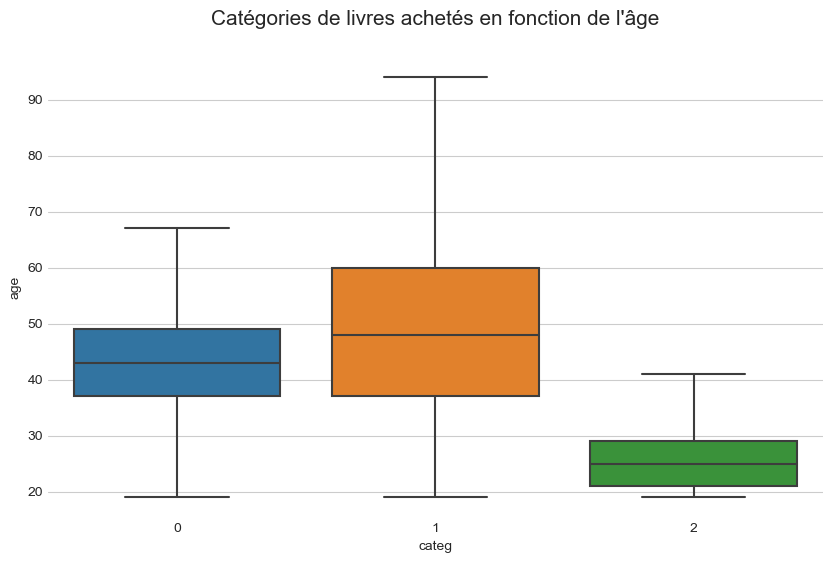

In [91]:
# Boxplot des catégories de livres achetés en fonction de l'âge
plt.figure(figsize=(10,6))
sns.boxplot(x= 'categ', y='age', data = transactions_products_customers, showfliers=False)
plt.title("Catégories de livres achetés en fonction de l'âge", fontsize=15, y=1.05)
plt.show()

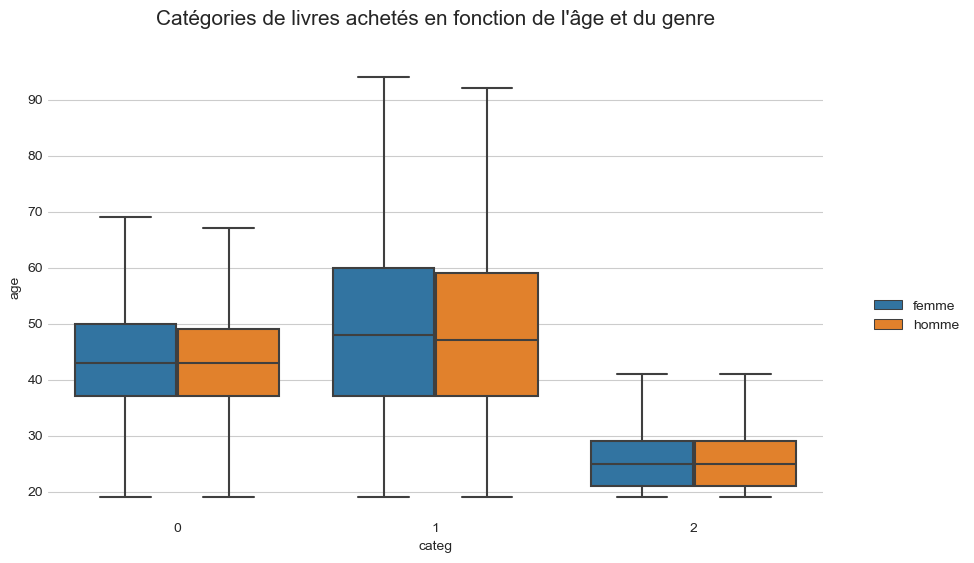

In [92]:
# Boxplot des catégories de livres achetés en fonction de l'âge avec la discrétisation selon les genres
plt.figure(figsize=(10,6))
sns.boxplot(x= 'categ', y='age', hue='Genre', data = transactions_products_customers, showfliers=False)
plt.title("Catégories de livres achetés en fonction de l'âge et du genre", fontsize=15, y=1.05)
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='upper left')
plt.show()

Les répartions entre les genres sont sensiblement égales. Nous pouvons donc continuer l'analyse sans se soucier de cette répartition.

Ici, nous ne pouvons pas utiliser un test de Student car il y a plus de 2 groupes indépendants. 

Nous pourrions donc utiliser le test d'égalité des moyennes ANOVA. 
Mais avant cela, il faut tester l'égalité des variances. Pour cela nous allons utiliser le test suivant : 

test de Levene : 
- H0 : Les variances des 3 catégories sont égales ; 
- H1 : Les variances des 3 catégories sont différentes

Seuil de sigificativité : 5%

In [93]:
# Test d'égalité des variances
stat, p = stats.levene(transactions_products_customers[transactions_products_customers.categ == 0]['age'],
            transactions_products_customers[transactions_products_customers.categ == 1]['age'],
            transactions_products_customers[transactions_products_customers.categ == 2]['age'],
            center = 'mean')

# Résultat
print("Statistique de test de Levene : ", stat)
print("p-valeur : ", p)
print() # Insertion d'une ligne vide (espace)

# Interprétation 
seuil_significativité = 0.05
if p > seuil_significativité:
    print("Les variances pour les 3 catégories sont significativement égales.\nNous ne pouvons pas rejeter l'hypothèse H0.")
else:
    print("Les variances pour les 3 catégories sont significativement différentes.\nNous pouvons rejetter l'hypothèse H0.")

Statistique de test de Levene :  24205.35459958229
p-valeur :  0.0

Les variances pour les 3 catégories sont significativement différentes.
Nous pouvons rejetter l'hypothèse H0.


Nous ne pouvons donc pas utiliser le test ANOVA. 

Le test non-paramétrique que nous allons donc utiliser est le test de Kruskal-Wallis.

Test de Kruskal-Wallis : 
- H0 : Les médianes des âges sont égales pour chaque catégorie de livre ; 
- H1 : Les médianes des âges sont différentes pour une ou plusieurs catégories de livre

Seuil de sigificativité : 5%

In [94]:
# Test de Kruskal-Wallis
stat, p_value = stats.kruskal(transactions_products_customers['age'], transactions_products_customers['categ'])

# Résultat
print("Statistique de test de Kruskal-Wallis : ", stat)
print("p-valeur : ", p_value)
print()

# Interprétation
seuil_significativité = 0.05
if p > seuil_significativité:
    print("Les médianes des âges pour les 3 catégories sont significativement égales.\nNous ne pouvons pas rejeter l'hypothèse H0.")
else:
    print("Les médianes des âges pour les 3 catégories sont significativement différentes pour une ou plusieurs catégories de livres.\nNous pouvons rejetter l'hypothèse H0.")

Statistique de test de Kruskal-Wallis :  981974.8818907437
p-valeur :  0.0

Les médianes des âges pour les 3 catégories sont significativement différentes pour une ou plusieurs catégories de livres.
Nous pouvons rejetter l'hypothèse H0.


In [95]:
# Calulons les médianes des âges pour les 3 catégories
médiane_categ0 = transactions_products_customers.loc[transactions_products_customers['categ'] == 0]['age'].median()
médiane_categ1 = transactions_products_customers.loc[transactions_products_customers['categ'] == 1]['age'].median()
médiane_categ2 = transactions_products_customers.loc[transactions_products_customers['categ'] == 2]['age'].median()

# Conclusion
print(f"L'age médian pour l'achat de livre de catégorie 0 est: {round(médiane_categ0)} ans.")
print(f"L'age médian pour l'achat de livre de catégorie 1 est: {round(médiane_categ1)} ans.")
print(f"L'age médian pour l'achat de livre de catégorie 2 est: {round(médiane_categ2)} ans.")

L'age médian pour l'achat de livre de catégorie 0 est: 43 ans.
L'age médian pour l'achat de livre de catégorie 1 est: 48 ans.
L'age médian pour l'achat de livre de catégorie 2 est: 25 ans.


### 4.3. Prix moyen d'un livre par rapport à la catégorie et à l'age moyen <a class="anchor" id="4_3"></a>

In [96]:
# Calculons le prix moyen des livres par catégorie
prixm_categ = round(transactions_products_customers.groupby('categ')['price'].mean(),2).reset_index().rename(columns={'price' : 'Prix moyen de la catégorie'})

# Dictionnaire catégories-âge moyen
dict_categ = {}
for categorie in prixm_categ.categ.unique():
    age_moyen = round(transactions_products_customers.loc[transactions_products_customers['categ'] == categorie]['age'].mean())
    dict_categ[categorie] = age_moyen

# Jointure avec transactions_products_customers
transactions_products_customers = pd.merge(transactions_products_customers, prixm_categ, on='categ', how='left')

# Affichage du prix moyen par catégorie avec l'âge moyen des clients
prixm_categ['Age moyen'] = prixm_categ['categ'].map(dict_categ)
prixm_categ

,categ,Prix moyen de la catégorie,Age moyen
0,0,10.64,45
1,1,20.48,49
2,2,76.23,27


### 4.4. Matrice de corrélation <a class="anchor" id="4_4"></a>

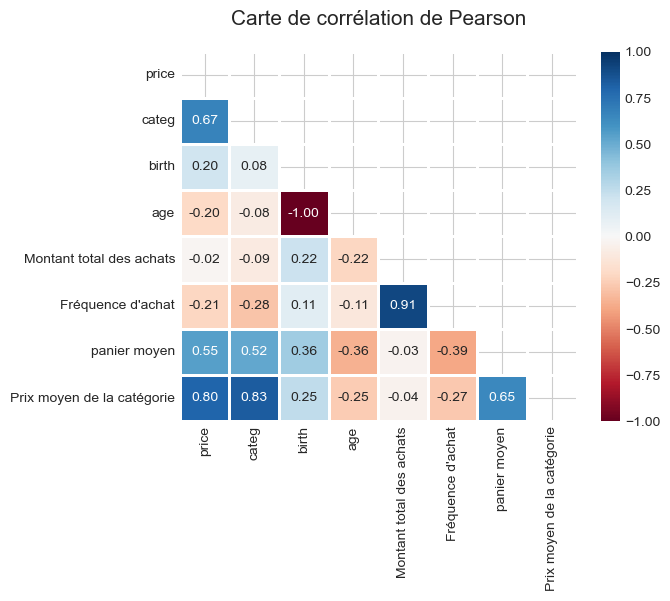

In [97]:
# Matrice de corrélation de Pearson
mask = np.triu(np.ones_like(transactions_products_customers.corr(), dtype=bool))
sns.heatmap(transactions_products_customers.corr(), mask=mask, center=0, cmap='RdBu', linewidths=1, annot=True, fmt='.2f', vmin=-1, vmax=1)
plt.title('Carte de corrélation de Pearson', fontsize=15, y=1.05)
plt.show()

## 5. Conclusion de l'étude des corrélations <a class="anchor" id="5"></a>

Les clients de moins de 30 ans ont des paniers moyens plus élevés que les autres tranches d'âge, mais leur fréquence d'achat est plus faible. 

La tranche d'âge des 30-50 ans est celle qui a la fréquence d'achat la plus élevée, nottons qu'à partir de 50 ans la fréquence d'achat a tendance à baisser. 

Les clients plus âgés ont des paniers moyens moins élevés en moyenne que les plus jeunes, mais leur fréquence d'achat est plus élevée, ce qui les rend importants pour le chiffre d'affaires total. 

En résumé, les moins de 30 ans achètent des livres plus coûteux mais moins souvent, tandis que les 30-50 ans achètent des livres moins coûteux mais plus souvent.